<a href="https://colab.research.google.com/github/jhoniers011/TrabajoTAE3/blob/main/TrabajoTae3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>
<p style="font-size: 45px;
          text-align:center;
          font-family: 'Roboto';
          font-variant: small-caps;
          font-weight: bold;
          line-height: 50px;"> Modelo de aprendizaje estadístico para clasificar imágenes de sujetos con gafas</p>
<br>

---


##### Carlos Mario Calle González
##### Catherine Andrea Córdoba Espinosa
##### Allison Piedrahita García
##### Santiago Ramírez Zapata
##### Jhonier Santiago Serna Cardona

19/08/2021


### **Objetivo** 
<div style="text-align: justify;width:100%;margin: 0 auto"> 
Construir y validar un modelo de aprendizaje estadístico para clasificar imágenes de sujetos con gafas de un conjunto de datos.
</div>
    
### **Planteamiento del problema**
<div style="text-align: justify;width:100%;margin: 0 auto"> 
Se cuenta con una base de datos de 640 imágenes en blanco y negro, en las cuales se pueden observar fotografías de 20 personas desde diferentes ángulos como:
</div>

*   ***Frontal:*** la posición de la persona es recta y mirando directamente al lente de la cámara.
*   ***Lateral izquierdo:*** la posición de la persona es el perfil izquierdo, es decir, la persona se encuentra mirando hacia el lado izquierdo tomando como referencia la posición de la cámara. 
*   ***Lateral derecho:*** la posición de la persona es el perfil derecho, es decir, la persona se encuentra mirando hacia el lado derecho tomando como referencia la posición de la cámara. 
*   ***Frontal superior:*** la posición de la persona es recta pero se encuentra mirando hacia arriba respecto a la posición de la cámara. 

<div style="text-align: justify;width:100%;margin: 0 auto"> 
Adicionalmente, se realizan variaciones para cada persona y para cada una de las posiciones, teniendo en cuenta cuatro expresiones faciales: feliz, triste, enojado y neutral. Asimismo, se toman fotografías para cada variación con gafas y sin gafas. Finalmente, se obtienen combinaciones como:
</div>

*   Mitchell, en posición frontal con expresión facial de enojo y con gafas (mitchell_straight_angry_sunglasses).
*   Danieln, en posición lateral izquierdo con expresión facial neutra y sin gafas (danieln_left_neutral_open)

<div style="text-align: justify;width:100%;margin: 0 auto"> 
Por otra parte, se evidencia que no todas las personas tienen las 32 fotografías de la combinación de las variaciones, hay personas que poseen mínimamente 28 imágenes, esto es debido a problemas en la adquisición de las fotografías con la cámara empleada. Además, se cuentan con tres tipos de resoluciones diferentes: alta, media y baja. Para este caso, se seleccionaron las imágenes con resolución alta (128 columnas x 120 filas). 
<br>
    
El propósito que se tiene con la base de datos es crear un modelo de aprendizaje estadístico que permita clasificar las imágenes en:
</div>

**1.**   ***Personas con gafas***
<br>
**2.**   ***Personas sin gafas***

### **Desarrollo del problema** 
Se inicia el desarrollo del promedio por medio de la importación de las librerias a utilizar:

In [1]:
#Librerias
import zipfile
import os
import cv2 as cv
import numpy as np
import glob
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report


#### **Lectura de datos**

Se cargan las imágenes contenidas en el repositorio de github al entorno de Colab.

In [2]:
%%capture

 #Link del repositorio de github
!wget --no-check-certificate \
    "https://github.com/jhoniers011/TrabajoTAE3/archive/refs/heads/main.zip" \
    -O "/tmp/imagenes.zip"


zip_ref = zipfile.ZipFile('/tmp/imagenes.zip', 'r') #Abre el archivo.zip en modo lectura
zip_ref.extractall('/tmp') #Extrae los archivos en la carpeta /tmp
zip_ref.close()



In [3]:
files = glob.glob('/tmp/TrabajoTAE3-main/Imagenes/**/*.pgm',recursive=True) #Se obtienen todas las url de las imágenes.

#### **Lectura de imágenes**

In [4]:
imagenes = [cv.imread(imagen,-1) for imagen in files] #Se cargan las imágenes y se guardan en una lista

#### **Exploración de la base de datos**

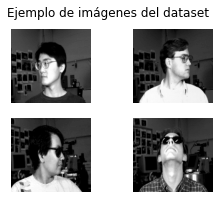

In [5]:
#Imprimir ejemplos de imágenes del dataset
fig = plt.figure(figsize=(4, 3))
fig.suptitle("Ejemplo de imágenes del dataset")
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(imagenes[100],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(imagenes[150],cmap = "gray")
plt.axis('off')
  

fig.add_subplot(rows, columns, 3)
plt.imshow(imagenes[200],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 4)
plt.imshow(imagenes[250],cmap = "gray")
plt.axis('off')

plt.show()


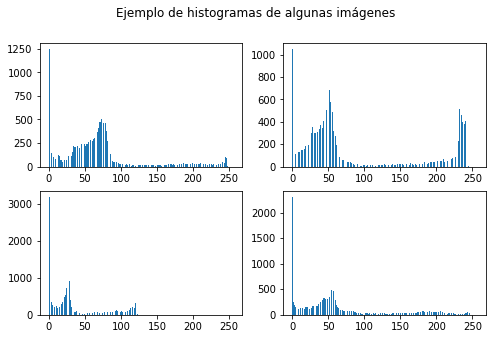

In [6]:
#Mostrando histogramas
fig = plt.figure(figsize=(8, 5))
fig.suptitle("Ejemplo de histogramas de algunas imágenes")
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.hist(imagenes[100].ravel(),256,[0,256])

fig.add_subplot(rows, columns, 2)
plt.hist(imagenes[150].ravel(),256,[0,256])

fig.add_subplot(rows, columns, 3)
plt.hist(imagenes[200].ravel(),256,[0,256])

fig.add_subplot(rows, columns, 4)
plt.hist(imagenes[250].ravel(),256,[0,256])

plt.show()

### **Procesamiento de imágenes**
#### **Segmentación de las imágenes**
<div style="text-align: justify;width:100%;margin: 0 auto">
Se aplica la tecnica de umbral, donde dado un valor limite, los valores menores se cambian a 0 y los mayores a 255, por lo que queda una imagen binarizada. Útil para resaltar caracteristicas de las imágenes.
En este caso, como las imágenes se han tomado en ambientes controlados (mismo fondo, misma iluminación, las gafas son las mismas,etc) se aplica la umbralización con el objetivo de eliminar el fondo lo más posible y resaltar las gafas. Se utilizó un valor de 100 como umbral según la forma de los histogramas.
</div>

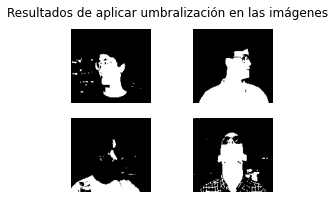

In [ ]:
#Umbralización de las imagenes
threshold_images = []
for imagen in imagenes:
  T,sal = cv.threshold(imagen,100,255,cv.THRESH_BINARY)
  threshold_images.append(sal)


#Mostrando ejemplos de umbralización de las imágenes
fig = plt.figure(figsize=(4, 3))
fig.suptitle("Resultados de aplicar umbralización en las imágenes")
rows = 2
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(threshold_images[100],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 2)
plt.imshow(threshold_images[150],cmap = "gray")
plt.axis('off')
  

fig.add_subplot(rows, columns, 3)
plt.imshow(threshold_images[200],cmap = "gray")
plt.axis('off')

fig.add_subplot(rows, columns, 4)
plt.imshow(threshold_images[250],cmap = "gray")
plt.axis('off')

plt.show()


#### **Obteniendo las etiquetas de las imágenes**

Se obtienen de los nombres de las imágenes la respectiva información para saber si tiene o no tiene gafas.

In [ ]:

labels = []
for image in files:
  aux = image.split("_")[3]
  labels.append(aux[:-4])

labels = np.array(labels)


Debido a que algunos clasificadores no reciben las clases o etiquetas en forma de texto, se binarizan quedando de la siguiente manera:  
* **0:** imagen de persona que **NO** tiene gafas  
* **1:** imagen de persona que **SI** tiene gafas

In [ ]:
#Binarizando las etiquetas
lb = preprocessing.LabelBinarizer()
labels = lb.fit_transform(labels)

### **Desarrollo del clasificador**

#### **Modelo 1: máquinas de soporte vectorial**
<div style="text-align: justify;width:100%;margin: 0 auto">
Se utilizará como clasificador una máquina de vectores de soporte, esta técnica utiliza un hiperplano para separar las muestras de datos a 2 o más espacios lo más amplio posibles (depende de las clases). Las observaciones que queden más cercanas al hiperplano se les llama vectores soporte y son los que definen el clasificador obtenido.
Tiene un hiperparámetro C que controla la penalización de errores de clasificación, entre más cerca de cero, menos se penalizan.
Esta separación no solo se puede hacer de forma lineal, si no que se puede utilizar funciones Kernel (polinómico, radial,etc) para obtener un espacio de mayor dimensionalidad. Por lo que tienen un parámetro gamma que ayuda a controlar la flexibilidad del modelo. 
</div>

In [ ]:
#Aplanamiento de imagenes
flatten_images = []
for image in threshold_images:
  flatten_images.append(image.flatten())

#### **Entrenamiento del modelo SVM**
Se dividen los datos en entrenamiento y validación.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(flatten_images,
                                                 labels.ravel(),
                                                 train_size = 0.8,
                                                 random_state = 1234,
                                                 shuffle = True
                                                 )



Se utilizará validación cruzada para obtener los mejores parámetros de C, Gamma y kernel para el modelo basado en máquinas de vectores de soporte

In [ ]:
param_grid = {'C':[0.1,1,10,100],'gamma':[0.0001,0.001,0.1,1],'kernel':['linear','rbf','poly']}

svc = SVC(probability=True)
model = GridSearchCV(svc,param_grid)

In [ ]:
#Buscamos los mejores parámetros
model.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=True, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.1, 1, 10, 100],
                         'gamma': [0.0001, 0.001, 0.1, 1],
                         'kernel': ['linear', 'rbf', 'poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Los mejores parámetros encontrados son:

In [ ]:
print("C:",model.best_params_["C"])
print("Gamma:",model.best_params_["gamma"])
print("Kernel:",model.best_params_["kernel"])

C: 0.1
Gamma: 0.0001
Kernel: linear


#### **Visualizando desempeño del modelo**

In [ ]:
pred = model.predict(X_test)
Classification_report_svm = classification_report(y_test,pred,labels=[0,1],target_names=["No tiene gafas","Tiene gafas"],output_dict=True)
Dataframe_score = pd.DataFrame(Classification_report_svm).T
Dataframe_score.round(2)

,precision,recall,f1-score,support
No tiene gafas,0.93,0.96,0.94,52.00
Tiene gafas,0.97,0.95,0.96,73.00
accuracy,0.95,0.95,0.95,0.95
macro avg,0.95,0.95,0.95,125.00
weighted avg,0.95,0.95,0.95,125.00


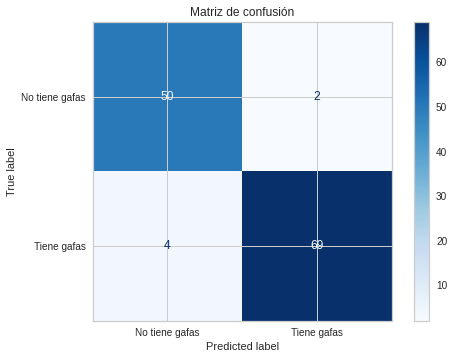

In [ ]:
matriz_conf_svm = plot_confusion_matrix(model,X_test,y_test,display_labels=["No tiene gafas","Tiene gafas"],cmap=plt.cm.Blues)
matriz_conf_svm.ax_.set_title("Matriz de confusión")
plt.show()

#### **Modelo 2: k vecinos más cercanos (KNN)**

Se desarrolla un segundo clasificador utilizando el método de los k vecinos más cercanos.

In [ ]:
#Se normalizan las imágenes
normalizadas = []
for image in threshold_images:
  normalizadas.append(image/255)

normalizadas = np.array(normalizadas)

#Se dividen los datos en entrenamiento y validación.

X_train, X_test, y_train, y_test = train_test_split(normalizadas,labels.flatten(),random_state = 42,test_size = 0.2)


X_train = np.reshape(X_train,(X_train.shape[0],-1))
X_test = np.reshape(X_test,(X_test.shape[0],-1))

Se busca el mejor valor de K para entrenar el modelo, se hace corriendo modelos Knn con valores de k desde 1 a 50, y se grafica la tasa de error respecto a su respectivo valor K, se busca minimizar esta tasa de error.

Text(0, 0.5, 'Error Rate')

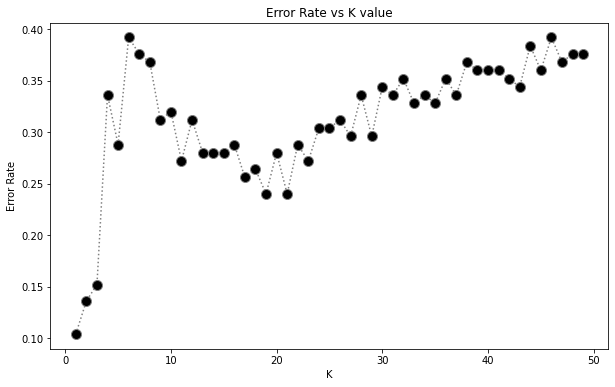

In [ ]:
#Buscando el mejor K

error_rate = []

for k in range(1,50):
  neigh = KNeighborsClassifier(n_neighbors=k)
  neigh.fit(X_train,y_train)
  pred_i = neigh.predict(X_test)
  error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='gray',linestyle='dotted',marker='o',markerfacecolor = 'black',markersize = 10)
plt.title('Error Rate vs K value')
plt.xlabel('K')
plt.ylabel('Error Rate')

Según la gráfica, el k que minimiza el error es K=1

In [ ]:
print("Error mínimo: ",round(min(error_rate),2), "en K =",error_rate.index(min(error_rate))+1)

Error mínimo:  0.1 en K = 1


Se entrena el modelo con K=1 y se visualiza el desempeño del modelo

In [ ]:
#Entrenamieto del modelo
knn_model = KNeighborsClassifier(n_neighbors=1).fit(X_train,y_train)

In [ ]:
#Metricas de desempeño
pred = knn_model.predict(X_test)
Classification_report_knn = classification_report(y_test,pred,labels=[0,1],target_names=["No tiene gafas","Tiene gafas"],output_dict=True)
Dataframe_score_knn = pd.DataFrame(Classification_report_knn).T
Dataframe_score_knn.round(2)

,precision,recall,f1-score,support
No tiene gafas,0.92,0.84,0.88,56.0
Tiene gafas,0.88,0.94,0.91,69.0
accuracy,0.90,0.90,0.90,0.9
macro avg,0.90,0.89,0.89,125.0
weighted avg,0.90,0.90,0.90,125.0


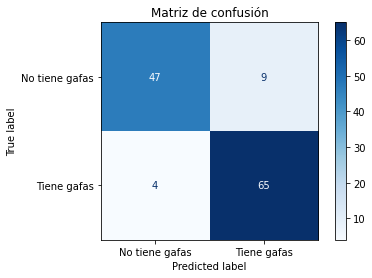

In [ ]:
#Matriz de confusión

matriz_conf_knn = plot_confusion_matrix(knn_model,X_test,y_test,display_labels=["No tiene gafas","Tiene gafas"],cmap=plt.cm.Blues)
matriz_conf_knn.ax_.set_title("Matriz de confusión")
plt.show()

### Conclusiones
* El modelo de clasificación basado en máquinas de vectores soporte tuvo muy buenos resultados, esto puede ser porque los datos son linealmente separables debido a que las imágenes fueron realizadas en ambientes controlados, lo que facilita el reconocimiento de características útiles en las imágenes. Además, las máquinas de vectores soporte son eficaces con datos de alta dimensionalidad, como es este caso.
 
* El modelo de clasificación basado en los k vecinos más cercanos obtuvo buenos resultados teniendo en cuenta que este método puede tener el problema de la maldición de la dimensionalidad, pero debido a la simplicidad de las imágenes, es capaz de diferenciarlas correctamente. El valor del mejor K (K=1) se puede deber a la similaridad que hay con los datos de entrenamiento y validación.


### Referencias

